In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "0"

import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

import index as myidx
import crystal_dd
import transform as mytrans

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platforms", 'cpu')


from ImageD11.parameters import AnalysisSchema
from ImageD11.columnfile import columnfile

%matplotlib widget

In [2]:
# set up detector

In [3]:
pars = AnalysisSchema.from_default().geometry_pars_obj
pars.set('tilt_x', 0.00123)
pars.set('tilt_y', -0.0345)
pars.set('tilt_z', 0.02)
pars.set('chi', 1)
pars.set('wedge', -3)
pars.set('t_x', 1)
pars.set('t_y', 2)
pars.set('t_z', 3)

In [4]:
pars.get('wavelength')

0.2845704

In [5]:
# make some g-vectors
# make some hkls first

In [6]:
import importlib
importlib.reload(crystal_dd)

<module 'crystal_dd' from '/home/esrf/james1997a/Code/Anri/anri/sandbox/crystal_dd.py'>

In [7]:
struc = crystal_dd.structure.from_cif('ICSD_CollCode43416.cif')

In [8]:
# computes all rings, but we don't know the intensities yet
struc.make_hkls(dsmax=1.0, wavelength=pars.get('wavelength'))

In [9]:
struc.rings_dict

{0:      h    k    l       tth        ds   intensity
 2 -1.0  1.0  0.0  6.382942  0.391277  261.613687
 3  1.0 -1.0  0.0  6.382942  0.391277  261.613687
 4  0.0 -1.0  0.0  6.382942  0.391277  262.183587
 5  1.0  0.0  0.0  6.382942  0.391277  261.613687
 6 -1.0  0.0  0.0  6.382942  0.391277  261.613687
 7  0.0  1.0  0.0  6.382942  0.391277  262.183587,
 1:      h    k    l       tth        ds   intensity
 8  0.0  0.0 -2.0  6.965661  0.426955  978.360958
 9  0.0  0.0  2.0  6.965661  0.426955  978.360958,
 2:       h    k    l       tth        ds   intensity
 10  1.0  0.0  1.0  7.272274  0.445724  707.931273
 11  0.0 -1.0  1.0  7.272274  0.445724  707.417717
 12  0.0 -1.0 -1.0  7.272274  0.445724  707.417717
 13  1.0  0.0 -1.0  7.272274  0.445724  707.931273
 14 -1.0  0.0 -1.0  7.272274  0.445724  707.931273
 15  0.0  1.0 -1.0  7.272274  0.445724  707.417717
 16  0.0  1.0  1.0  7.272274  0.445724  707.417717
 17 -1.0  0.0  1.0  7.272274  0.445724  707.931273
 18 -1.0  1.0  1.0  7.272274  

In [10]:
struc.ringds

array([0.39127669, 0.4269554 , 0.44572432, 0.57912724, 0.6777111 ,
       0.75050117, 0.78255337, 0.80098892, 0.81114888, 0.8539108 ,
       0.89144865, 0.93928755])

In [11]:
struc.ringhkls

{0.39127668517244407: array([[-1.,  1.,  0.],
        [ 1., -1.,  0.],
        [ 0., -1.,  0.],
        [ 1.,  0.,  0.],
        [-1.,  0.,  0.],
        [ 0.,  1.,  0.]]),
 0.42695540237344515: array([[ 0.,  0., -2.],
        [ 0.,  0.,  2.]]),
 0.44572432428969316: array([[ 1.,  0.,  1.],
        [ 0., -1.,  1.],
        [ 0., -1., -1.],
        [ 1.,  0., -1.],
        [-1.,  0., -1.],
        [ 0.,  1., -1.],
        [ 0.,  1.,  1.],
        [-1.,  0.,  1.],
        [-1.,  1.,  1.],
        [ 1., -1., -1.],
        [ 1., -1.,  1.],
        [-1.,  1., -1.]]),
 0.579127239883781: array([[-1.,  0., -2.],
        [ 1., -1.,  2.],
        [-1.,  1., -2.],
        [ 0.,  1., -2.],
        [ 0.,  1.,  2.],
        [ 0., -1., -2.],
        [ 1.,  0.,  2.],
        [ 0., -1.,  2.],
        [ 1., -1., -2.],
        [ 1.,  0., -2.],
        [-1.,  1.,  2.],
        [-1.,  0.,  2.]]),
 0.677711098535805: array([[ 1.,  1.,  0.],
        [-1., -1.,  0.],
        [ 2., -1.,  0.],
        [-1.,  2

In [12]:
struc.ringmult

array([ 6,  2, 12, 12,  6, 12,  6, 12, 12,  2, 12, 12])

In [13]:
B = struc.B

In [14]:
from scipy.spatial.transform import Rotation as R
U_in = R.random(1).as_matrix()[0]

In [15]:
U_in

array([[-0.47751729, -0.54186732, -0.6916336 ],
       [-0.37006813, -0.58991043,  0.71767351],
       [-0.7968857 ,  0.59865306,  0.08116461]])

In [16]:
all_hkls = np.concatenate(list(struc.ringhkls.values()))

In [17]:
gve = (U_in @ B @ all_hkls.T).T

In [18]:
gve.shape

(106, 3)

In [19]:
# all we need to test indexing

In [20]:
# does ImageD11 index it?

In [21]:
import ImageD11.indexing
import ImageD11.unitcell
import ImageD11.grain

In [22]:
struc.lattice_parameters

(2.95111, 2.95111, 4.68433, 90.0, 90.0, 120.0)

In [23]:
idx = ImageD11.indexing.indexer(unitcell=ImageD11.unitcell.unitcell(struc.lattice_parameters, int(struc._sym.spacegroup_number)),
                                gv=gve,
                                wavelength=pars.get('wavelength'))

info: gv: [[-0.09019406 -0.12749491  0.35875831]
 [ 0.09019406  0.12749491 -0.35875831]
 [ 0.27703544  0.27229394 -0.04695552]
 [-0.18684138 -0.14479903 -0.31180279]
 [ 0.18684138  0.14479903  0.31180279]
 [-0.27703544 -0.27229394  0.04695552]
 [ 0.2952967  -0.30641458 -0.03465367]
 [-0.2952967   0.30641458  0.03465367]
 [-0.33448974  0.00840826 -0.29447596]
 [ 0.12938709  0.42550123 -0.02962868]
 [ 0.42468379  0.11908665 -0.06428235]
 [-0.03919303 -0.29800632 -0.32912963]
 [ 0.33448974 -0.00840826  0.29447596]
 [-0.12938709 -0.42550123  0.02962868]
 [-0.42468379 -0.11908665  0.06428235]
 [ 0.03919303  0.29800632  0.32912963]
 [-0.23784241  0.02571238  0.37608514]
 [ 0.23784241 -0.02571238 -0.37608514]
 [-0.0574543   0.2807022  -0.34143148]
 [ 0.0574543  -0.2807022   0.34143148]
 [ 0.48213809 -0.16161555  0.27714913]
 [-0.20510265  0.43390949 -0.32410464]
 [ 0.20510265 -0.43390949  0.32410464]
 [ 0.01826126 -0.57870852  0.01230185]
 [-0.57233214  0.03412064  0.08160918]
 [ 0.57233214 -

In [24]:
idx.assigntorings()

info: Assign to rings, maximum d-spacing considered: 0.939288
info: Ring assignment array shape (106,)
info: Ring     (  h,  k,  l) Mult  total indexed to_index  ubis  peaks_per_ubi   tth
info: Ring 11  ( -1,  0, -4)   12     12       0       12   N/A     N/A  15.36
info: Ring 10  (  0, -2, -2)   12     12       0       12   N/A     N/A  14.57
info: Ring 9   (  0,  0, -4)    2      2       0        2   N/A     N/A  13.96
info: Ring 8   ( -2,  0, -1)   12     12       0       12   N/A     N/A  13.26
info: Ring 7   (  1, -2, -2)   12     12       0       12   N/A     N/A  13.09
info: Ring 6   ( -2,  0,  0)    6      6       0        6   N/A     N/A  12.79
info: Ring 5   (  0, -1, -3)   12     12       0       12   N/A     N/A  12.26
info: Ring 4   ( -1, -1,  0)    6      6       0        6   N/A     N/A  11.07
info: Ring 3   ( -1,  0, -2)   12     12       0       12   N/A     N/A  9.45
info: Ring 2   (  0, -1, -1)   12     12       0       12   N/A     N/A  7.27
info: Ring 1   (  0,  0,

In [25]:

idx.ring_1 = 0
idx.ring_2 = 2
# idx.score_all_pairs()
idx.find()
# idx.scorethem()
# grains = [ImageD11.grain.grain(ubi) for ubi in idx.ubis]
# U_id11 = grains[0].U
# print(U_id11)

info: hkls of rings being used for indexing
info: Ring 1: [(-1, 0, 0), (0, -1, 0), (-1, 1, 0), (1, -1, 0), (0, 1, 0), (1, 0, 0)]
info: Ring 2: [(0, -1, -1), (1, -1, -1), (-1, 0, -1), (0, -1, 1), (1, -1, 1), (1, 0, -1), (-1, 0, 1), (-1, 1, -1), (0, 1, -1), (1, 0, 1), (-1, 1, 1), (0, 1, 1)]
info: Possible angles and cosines between peaks in rings:
info: 28.616560 0.877845
info: 63.964861 0.438922
info: 116.035139 -0.438922
info: 151.383440 -0.877845
info: Number of peaks in ring 1: 6
info: Number of peaks in ring 2: 12
info: Minimum number of peaks to identify a grain 10
info: Number of trial orientations generated 6
info: Time taken 0.000062 /s


In [26]:
ringds1 = struc.ringds[idx.ring_1]
ringds2 = struc.ringds[idx.ring_2]

hkls1 = struc.ringhkls[ringds1]
hkls2 = struc.ringhkls[ringds2]

In [27]:
# U_id11, U_in

In [28]:
# make scattering vectors on the detector
(sc_one, fc_one), (sc_two, fc_two), (omega1, omega2) = mytrans.g_to_det(gve, jnp.array((pars.get('t_x'), pars.get('t_y'), pars.get('t_z'))),
                            pars.get('wedge'), pars.get('chi'), pars.get('wavelength'),
                            pars.get('y_center'), pars.get('y_size'), pars.get('tilt_y'),
                              pars.get('z_center'), pars.get('z_size'), pars.get('tilt_z'),
                              pars.get('tilt_x'),
                              pars.get('distance'),
                              pars.get('o11'), pars.get('o12'), pars.get('o21'),pars.get('o22'))

In [29]:
sc = np.concatenate((sc_one, sc_two))
fc = np.concatenate((fc_one, fc_two))
omega = np.concatenate((omega1, omega2))

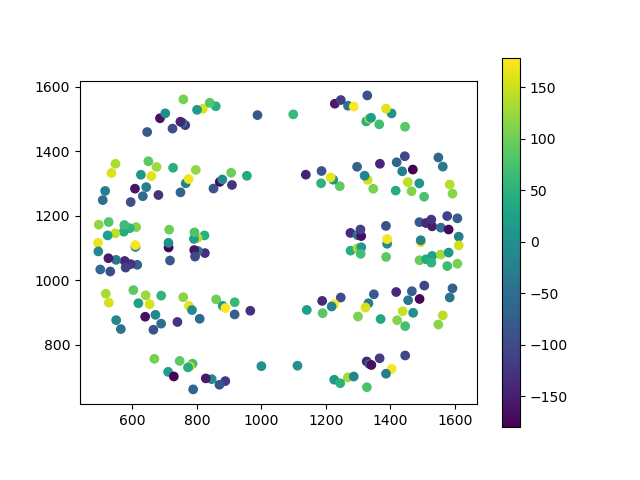

In [30]:
fig, ax = plt.subplots()
scat = ax.scatter(fc, sc, c=omega)
ax.set_aspect(1)
plt.colorbar(scat)
plt.show()

In [31]:
# ok so ImageD11 works
# now we need to

In [32]:
# peaks -> gvecs -> assign to rings -> score all pairs

In [33]:
import importlib
importlib.reload(myidx)

<module 'index' from '/home/esrf/james1997a/Code/Anri/anri/sandbox/index.py'>

In [34]:
# assign peaks to rings
ds = myidx.g_to_ds(gve)
ra = myidx.assign_peaks_to_rings(ds, struc.ringds, idx.ds_tol)
assert np.allclose(ra, idx.ra)

In [35]:
# (N1, N2) array of theoretical angles between hkls
cangs_id11 = ImageD11.unitcell.cosangles_many(hkls1, hkls2, idx.unitcell.gi)
cangs_me = myidx.anglehkls(hkls1, hkls2, struc.rmt)
assert np.allclose(cangs_id11, cangs_me)

In [100]:
# over npks, for each peak in ring 1, which peak in ring 2 does it like the best, if any < costol
res = myidx.assign_hits(gve, ra, idx.ring_1, idx.ring_2, hkls1, hkls2, struc.rmt, tol=1e-5)
resprint = np.column_stack((res['diffs'][res['mask']], res['i1'][res['mask']], res['i2'][res['mask']]))
print(resprint)
import pprint
pprint.pprint(idx.hits)
print(np.unique(res['coses']))
print(idx.cosangles)

[[ 0.  0. 10.]
 [ 0.  1. 10.]
 [ 0.  2.  9.]
 [ 0.  3.  8.]
 [ 0.  4.  8.]
 [ 0.  5.  9.]]
[[1.1102230246251565e-16, 0, 12],
 [1.1102230246251565e-16, 1, 8],
 [0.0, 2, 10],
 [1.1102230246251565e-16, 3, 8],
 [1.1102230246251565e-16, 4, 8],
 [0.0, 5, 10]]
[-0.87784459 -0.87784459 -0.43892229 -0.43892229 -0.43892229 -0.43892229
 -0.43892229  0.43892229  0.43892229  0.43892229  0.43892229  0.43892229
  0.87784459  0.87784459]
[ 0.87784459  0.43892229 -0.43892229 -0.87784459]


In [37]:
bt_me = myidx.BTmat(hkls1[5], hkls2[6], struc.B, np.linalg.inv(struc.B))
bt_id11 = ImageD11.unitcell.BTmat(hkls1[5], hkls2[6], struc.B, np.linalg.inv(struc.B))
assert np.allclose(bt_me, bt_id11)

In [38]:
bt_me

Array([[-1.94535253e-16,  4.17847091e-17,  2.95111000e+00],
       [ 2.55573623e+00, -7.81730278e-17, -1.47555500e+00],
       [ 0.00000000e+00, -4.68433000e+00, -3.25495127e-16]],      dtype=float64)

In [39]:
UBI = np.linalg.inv(U_in @ struc.B)
score_id11 = ImageD11.cImageD11.score(UBI, gve, 0.01)
score_me = myidx.score(UBI, gve, 0.01)
assert score_id11 == score_me

In [82]:
bt_me = myidx.BTmat(hkls1[4], hkls2[5], struc.B, np.linalg.inv(struc.B))
UBI_in = np.linalg.inv(U_in @ struc.B)
UBI_id11 = UBI_in.copy()
ImageD11.cImageD11.quickorient(UBI_id11, bt_me)
UBI_me = myidx.quickorient(UBI_in, bt_me)
assert np.allclose(UBI_id11, UBI_me)

In [42]:
from ImageD11 import cImageD11

def filter_pairs(h1, h2, c2a, B, BI, tol=1e-5):
    """ remove duplicate pairs for orientation searches
    h1 = reflections of ring1, N1 peaks
    h2 = reflections of ring2, N2 peaks
    c2a  = cos angle between them, N1xN2
    B = B matrix in reciprocal space
    BI = inverse in real space
    """
    assert c2a.shape == (len(h1), len(h2))
    order = np.argsort(c2a.ravel())  # increasing in cosine of angle
    c2as = c2a.flat[order]
    hi, hj = np.mgrid[0:len(h1), 0:len(h2)]
    hi = hi.ravel()[order]  # to get back the peaks
    hj = hj.ravel()[order]
    # Results holders:
    pairs = []
    cangs = []
    matrs = []
    # cluster the cangs assuming a sensible threshold
    dc = (c2as[1:] - c2as[:-1]) > 1e-8  # differences
    inds = list(np.arange(1, len(dc) + 1, dtype=int)[dc]) + [len(c2as) - 1, ]
    p = 0  # previous
    for i in inds:
        c = c2as[p:i]  # block is p:i
        if abs(c2as[p]) < 0.98:  # always keep the first one
            ha = h1[hi[p]]
            hb = h2[hj[p]]
            pairs.append((ha, hb))
            cangs.append(c2as[p])
            BT = ImageD11.unitcell.BTmat(ha, hb, B, BI)
            matrs.append(BT)
            print('left', (hi[p], hj[p]))
        else:

            p = i
            continue
        if len(c) == 1:
            p = i
            continue
        assert (c.max() - c.min()) < 2.1e-8, "Angles blocking error in filter_pairs"
        # here we have a bunch of hkl pairs which all give the same angle
        # between them. They are not all the same. We generate a pair of peaks
        # from the first one and see which other pairs index differently
        ga = np.dot(B, ha)
        # print('left', hi[p], hj[p], ha, ga)
        gb = np.dot(B, hb)
        assert abs(np.dot(ga, gb) / np.sqrt(np.dot(ga, ga) * np.dot(gb, gb)) - c2as[p]) < 2e-8, "mixup in filter_pairs"
        gobs = np.array((ga, gb, (0, 0, 0)), float)
        UBI = gobs.copy()
        cImageD11.quickorient(UBI, BT)
        
        gtest = [np.dot(np.linalg.inv(UBI), HKL0).T.copy(), ]
        for j in range(p + 1, i):
            ha = h1[hi[j]]
            hb = h2[hj[j]]
            BT = ImageD11.unitcell.BTmat(ha, hb, B, BI)
            newpair = True
            for gt in gtest:
                UBI = gobs.copy()
                cImageD11.quickorient(UBI, BT)
                npk = cImageD11.score(UBI, gt, 1e-6)
                if npk == len(HKL0[0]):
                    newpair = False
                    break
            if newpair:
                pairs.append((ha, hb))
                cangs.append(c2as[j])
                matrs.append(BT)
                gtest.append(np.dot(np.linalg.inv(UBI), HKL0).T.copy())
                print('right', (hi[j], hj[j]))
        p = i
    return pairs, cangs, matrs

In [46]:
@jax.jit
def test_combo(gobs, BT, gt):
    # gobs from the left
    # bt from the right
    # gtest from the left
    UBI = myidx.quickorient(gobs, BT)
    npk = myidx.score(UBI, gt, 1e-6)
    return npk


# vmap over the second axis (j)
test_combo_right = jax.vmap(test_combo,
                            in_axes=(None, 0, None))  # BT varies

# vmap over the first axis (i)
test_combo_both = jax.vmap(test_combo_right,
                           in_axes=(0, None, 0))  # gobs and gt vary


@jax.jit
def derive_arrays(ha, hb, B, BI, HKL0):
    BT = myidx.BTmat(ha, hb, B, BI)
    ga = jnp.dot(B, ha)
    gb = jnp.dot(B, hb)
    gobs = jnp.array((ga, gb, (0, 0, 0)))
    UBI = myidx.quickorient(gobs, BT)
    UB = jnp.linalg.inv(UBI)
    gtest = (UB @ HKL0).T
    return BT, gobs, gtest


derive_arrays_2d = jax.jit(jax.vmap(jax.vmap(derive_arrays, in_axes=[None, 0, None, None, None]), in_axes=[0, None, None, None, None]))


@jax.jit
def filter_pairs_jax(hkls1, hkls2, c2a, B, BI, tol=1e-5):
    """ remove duplicate pairs for orientation searches
    h1 = reflections of ring1, N1 peaks
    h2 = reflections of ring2, N2 peaks
    c2a  = cos angle between them, N1xN2
    B = B matrix in reciprocal space
    BI = inverse in real space
    """
    HKL0 = jnp.array([[0, 0, 1, 1, -1, 1, -1, 0, 0, 1, -1, 1, 1, 3, 11],
                     [0, 1, 0, 1, 1, 0, 0, 1, -1, 1, 1, -1, 1, 2, 12],
                     [1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, -1, 1, 13]],)  # first unit cell

    N1 = hkls1.shape[0]
    N2 = hkls2.shape[0]
    M = N1 * N2

    btmats, gobs, gtest = derive_arrays_2d(hkls1, hkls2, B, BI, HKL0)
    gobs_flat = gobs.reshape((M, 3, 3))
    bt_flat = btmats.reshape((M, 3, 3))
    gt_flat = gtest.reshape((M, -1, 3))
    # test each (gobs and gtest) from the left with (bt) from the right
    scores = test_combo_both(gobs_flat, bt_flat, gt_flat)

    return scores


In [ ]:
# you have a pair of observed g-vectors
# the cosangle between them matches one of the theoretical cosangles
# but different hkl pairs can have the same cosangle
# so you need to go back to determine the possible hkl pairs for the pair of observed g-vectors
# then determine a ubi for each of them
# what if we just do (npks, npks, nhkls1, nhkls2)
# for each pair of observed peaks, work out a ubi from the hkls

In [131]:
# @jax.jit
# def orient_single(g1, g2, h1, h2, B, BI):
#     # get a UBI for a single combination of g1, g2, h1, h2
#     BT = myidx.BTmat(h1, h2, B, BI)
#     gobs = jnp.array((g1, g2, (0, 0, 0)))
#     UBI = myidx.quickorient(gobs, BT)
#     return UBI

@jax.jit
def my_eval(g1, g2, BT):
    gobs = jnp.array((g1, g2, (0, 0, 0)))
    UBI = myidx.quickorient(gobs, BT)
    return UBI

bt_2d = jax.jit(jax.vmap(jax.vmap(myidx.BTmat, in_axes=(0, None, None, None)), in_axes=(None, 0, None, None)))

score_2d = jax.jit(jax.vmap(jax.vmap(myidx.score, in_axes=(0, None, None)), in_axes=(None, 0, None)))

@jax.jit
def orient_jax(
    gv: jnp.ndarray,     # (N,3)
    ra: jnp.ndarray,     # (N,)
    ring1: int,
    ring2: int,
    hkls1: jnp.ndarray,  # (M,3)
    hkls2: jnp.ndarray,  # (K,3)
    B,
    BI,
    hkl_tol: float = 0.01,):

    # normalize them
    gv_n = myidx.unit_many(gv)
    
    # Masks for ring membership
    mask1 = (ra == ring1)                      # (N,)
    mask2 = (ra == ring2)                      # (N,)

    # Mask out non-ring entries with NaN
    n1 = jnp.where(mask1[:, None], gv_n, jnp.nan) # (N,3)
    n2 = jnp.where(mask2[:, None], gv_n, jnp.nan) # (N,3)

    allbt = bt_2d(hkls1, hkls2, B, BI)  # (M, K, 3, 3)
    # I just need to call eval batching over n1, n2 with bt[i,j] passed in

    # Vectorize eval over all dimensions: n1 (N), n2 (N), hkls1 (M), hkls2 (K)
    batched_eval = jax.vmap(  # over n1 dimension
        jax.vmap(  # over n2 dimension  
            jax.vmap(  # over hkls1 dimension (M)
                jax.vmap(my_eval, in_axes=(None, None, 0)),  # over hkls2 dimension (K)
                in_axes=(None, None, 0)  # over hkls1 dimension (M)
            ),
            in_axes=(None, 0, None)  # over n2 dimension
        ),
        in_axes=(0, None, None)  # over n1 dimension
    )
    
    # Compute all UBIs
    UBIs = batched_eval(n1, n2, allbt)  # (N, N, M, K, 3, 3)

    # compute all scores
    scores = score_2d(UBIs, gv, hkl_tol)
    return scores

In [132]:
# @jax.jit
# def orient_jax(g1, g2, hkls1, hkls2, c2a, B, BI, tol=1e-5):
#     # this will be called on hits where we have (diff, pk1, pk2)
#     # (N1, N2, 3, 3):
#     btmats = jax.jit(jax.vmap(jax.vmap(myidx.BTmat, in_axes=[None, 0, None, None]), in_axes=[0, None, None, None]))(hkls1, hkls2, B, BI)
#     costheta = np.dot(g1, g2) / np.sqrt((g1 * g1).sum() * (g2 * g2).sum())
#     angles_match_mask = jnp.abs(c2a - costheta)
#     return btmats

In [133]:
%%time

ubis = orient_jax(gve, ra, idx.ring_1, idx.ring_2, hkls1, hkls2, struc.B, np.linalg.inv(struc.B))

TypeError: dot_general requires contracting dimensions to have the same shape, got (3,) and (12,).

In [128]:
ubis[~np.isnan(ubis)].reshape(-1, 3,3)[0]

Array([[-0.42085322, -0.07535124, -2.91997517],
       [-1.59911006, -1.74089057,  1.76669105],
       [-3.23984004,  3.36181954,  0.38020181]], dtype=float64)

In [121]:
np.where(~np.isnan()))

(array([0, 0, 0, ..., 5, 5, 5]),
 array([ 8,  8,  8, ..., 19, 19, 19]),
 array([ 0,  0,  0, ..., 11, 11, 11]),
 array([0, 0, 0, ..., 5, 5, 5]),
 array([0, 0, 0, ..., 2, 2, 2]),
 array([0, 1, 2, ..., 0, 1, 2]))

In [86]:
jnp.searchsorted(jnp.unique(cangs_me), 0.438)

Array(7, dtype=int32)

In [90]:
jnp.unique(cangs_me)[8]

Array(0.43892229, dtype=float64)

In [ ]:
def orient_id11(g1, g2, ring_1, ring_2):
    # normalized dot product
    # get angle between g1 and g2
    costheta = np.dot(g1, g2) / np.sqrt((g1 * g1).sum() * (g2 * g2).sum())
    # get symmetry-reduced angles and hkl pairs for these rings
    hab, c2ab, matrs = self.getanglehkls(ring1, ring2)
    if crange > 0:
        best = np.arange(len(c2ab), dtype=int)[abs(c2ab - costheta) < crange]
        if verbose == 1:
            print("possible best", best, len(c2ab))
    else:
        # just get closest single index to hkl pairs
        i = np.searchsorted(c2ab, costheta, side='left')
        if i > 0 and (i == len(c2ab) or
                      (fabs(costheta - c2ab[i - 1]) < fabs(costheta - c2ab[i]))):
            best = [i - 1, ]
        else:
            best = [i, ]
    if verbose == 1:
        print("g1, g2", g1, g2)
        print("observed cos2theta", costheta)
        print("hab, c2ab", hab, c2ab)
        print("best", best)
    self.UBIlist = 1XuXY/qORnCyVD4sfzcivdR4jmQgLABjClW1eeW7zUaxBoUopJXTqV+6a/d8tRfvtuHblZ+cTEhzN++hBato+pryY3iPa929C+d+2nDwgM9uepD+7g0ae+wR3sV76rRVO4ooIxawp0AxRoTgP/ZIfX87ldVecME+cuTSke7DGWh9Z973WfazuMpWVIB9y8Uum5TEpjf16izwHgxqzN/GffWxiGgX4yIf3aE+tZfWItV7aaxtSW9ZuIvjoyiwv549LZuA29XHhXGgjO3L2BTuEr8DZ2GWCtupSeW9eJ9G8m0zlOK+dW4+NFsyYBYAOICPDn4VEj+OfvSytsMylFoNXKAyNLepQcdicv3vMRK+ZtwWTWytKWfPXGQq74w1hueeoSqbNYA8V+FtwhnofmlFKYi8Av28AdZiJicy6alw5bTVOyCERUaUpCTwpcdp7fuoAitxOzKqnyoSmN2zoN5Z5u53OkIKXK8xiGgUXz7W0725HN6/vexm2U/+JSGgh+kziL9kHt6Bnqe8k5X7gNnaXJ+1mVdhgdg/T8Ypxu3evUNE0pHPoJzF4GCsL8ikgIzSAxJ9JrL6tJaVzYoXPtPIGGJnMARRUkAGwgtw3qT4ifjdeWryI1P7/s8cGtE/i/cWNoGx4GwJtPfcPK+VsBcLvKRyHfvvUrETEhtB7fmZnLN7Jy3xF0w6Bv63huGNGPMd061NvzqSsncgrZsT8JUPTo2IKIWlps8dP8rWia8rraWAFt9UD+MHkEL/76jdfzKE0x+fIBtdIm0bxNb9efi1r1ZEHSLpIKcwi3BjCpZXci/UqmerQOjCXKFkqG3XuKIh2DwZG+BWaL05ZVCP5Op6HxS8qiegsA04qTWXtiGTnObILNoQyKGEGRy4/bl3/B0YIszCfn3RUVaRiVTFvXDYNch5UIP8/TNQAmdNjBh5tGgeE5vrmj78BmUwu8ofIAiqZDAsAGdFXvnlzesztbU1LJtztoGx5GQlho2fbMlBwWfrXa42rYUh+98jP7DmzGZNZwn9xv/aFE1h48xq3nD+DBSSPRdZ1Vi3Yy74vVHD2QRlCIP6On9GXSVYMIbaR57AqKHPx75q8sWLGr7HmZNMXE4d158KYLCPT3rR5dckqO1+CvlKvIxdixPTlyczJffbgczaTQTyaLNpk0DMPg0WcvJyYutNLzCFEqyGLjsjZ9PW4zKY1r24zjP3u/87hdQzEosittAmN9asOevL0YlXTv6Ojsyt3jdXtt0Q2d7xM/ZUn6L2inBXY/J89l7fGuFLpK2ugyTn7xVRolYZv3EY/N6e24IGEX3uqstw1P58Ux3XhpdSKphfmok2e0mUzc2XcQ9w8YVivPTYimQALABmbSNPrFe04oun7xziqDFHtuMdYMO46YU2UB9JPjxO8vWc/Ati1Z9tZKlv28rSz3XUZKDh+9+guzP1rOi5/eSUKHxjWX0OF08afnvmHXodRyz9+tG8xfsZMjySd466/TsfhQrD48LIDDR72n4gEIP9nbeMt94+k9oB2zv1jNri3HMJk1Bo/qwqXXDKFDl/pL1i2av6nxw0grzuLLo79hOjlMXPpv99C2PNH9+npph6pisURtWJDyA0vSfwFODT8DHM8LJ8/p5sxAT9N03G4TYKBpJSlzdF1h6CXBo0kpTIwm0HyCQlcaxhkJnBUaMf79GNdyMtM6KpYmHuZobjYhVj8uaNOeUJsPpVUaIxkCFlWQALARsxc7Ks0XWEq5PW83aYp/f70Yx/y9QPn8d4ZukJtdyNN3zeTdXx6utRW2tWHhqj3sOOB5PpSuG+zYn8yvq/cwaUTNh6gmjO3Jxi0VK42UUgomje9Zdn/AsI4MGNb8kuWKxkUpxe0dpjAhbiA/J68hqSiDYHMAY2L7cV54J7RaSEPSI7QbO3N3e+0F1NDoEer7KuPKOHQ7i1LnetyWUuC52Lhm1lEY+Ac4MJlL2m4Y4HKaKCqw4dY1buk2ir7RE1mR8ndSitaVHasw0S54EoNiHkZTJlAwpnX7KttZ6MqjyF1IsDkUq6mJBYi+pnKRALDZkwCwEWvXrWWVwZ8BOEM95+dz6wYHc3No6eUUulsn6Ugmf/vT5+QVOfD3tzJ8TFcumNwbv5NDrIZhoBsGpnoMEH9cvK3SwFdTijmLt/kUAI45vytff7+Ow0czKvSymjRFdHQIF07sXePzC+GLNoGx3NVxap2ce1T0CGYfn4tTd3oMAnV0JsWNr5Nrl9qftxu7Xuxxm1vX8DTMaza7sfqf0aunwGxxExxayE1txjKsRUnWgPGtXifXcZSM4h0oZSbO/zz8zdUvIXmkYA8LUr5mX37J/GuTMnNe2CgmtLiKUItvpSiFaCwkAGzEeg7uQMv2MSQfSS+be1aOgqKEAPQA779Gw1V5vkEDWLtkN7rVjFKwftV+PntvCbf/+SLmb93P7xv343LrtIkNZ/q4flw2qhdmH4ZeqyM1M6/SwFc3DFIz8ny6hs1q5pUXruYfL81l7fpDQMmHiWFA924t+ctjFxMc1MS+8QtRDaGWEB7ofA8v73kdt+EuG37V0NDRub7N1XQNqduVsA7de1qlIKudfIftjJW6BlZLSfB3ZtIDpUq+FB4oPlbu8RBra0KsZ79Cf0/uJj489EK54NhtuNiQ9Tu78zZxb6fnCLNGnfV5650MAYsqSADYiCmlePzNm3jk8tdwFjtxnzaEq5k0bGF+JA2K9nq8SSn8k6vOfVW6yKQ05srMyOfZh78ir3swpXHn0bQsXvrsN5ZtOcgr915Sp0FgVHggqZm5eIsBlSrZx1ehIf68+PcrOZqYyeatxzB0g549WtKhXeOaEylEbesZ2p2X+vyDxWlL2Zi9GV130zmkE2NjxtAmMKHOr9/Cv6XXbQkh2STnl19YZTLpFQK/0+kYrEjfS1pxLjF+IV73y3MWMi95HUvStlHsdtI5uCWXthpK15CS5+w2XHx59A0M9Aq9ozo6Ba4c5iZ9zPVtH6zGs2xgEgCKKkgA2Mh17JXA6z8/ytf/XcDvszbgdLgICPJj0rVDGff/7d13eFRV+sDx770zk5n0hPRA6EjvIFUBpShNxYYogrqKXcS+rnV/6OoquqvuqqsruKhYwY4UAek99E4gtBAgvU275/dHyEBIJglkElLez/PMA7n3zL3n3kxm3jnlPRP7c/MnX2M4nJ6JH0U0CgPIhukaZy8op0waymQCpdCcbjTAOCdxljIUJgeY0p24wwq7l4sOv2rbAWYt3Mhtw6ou9cnIAR3YuueY1/1KwciBHbzuP1+NG0XQuJF064j6JcLagBsSruWGhGur/dwxtnhaBLUhKWd3sQkgAOG2fJqGpHMgK9wzS7eodb6sIFABx/IzvAaA+3KOMXnDB2Q5cz2xTVJuCr8cW8uEpoO5q8UwtmeuJ9ftfSUQA4MtmavJcWUSZJbZ/6J2qzkj/4VXjVpEM2Xabcze+ybf7Hydr3e8xt0vjKFZk2g+uOM6AqyWYp0luqZhNum8OW4Et97cHwBl1nFGBOKMDcUVFYQrOhhnTDDuAL8zy6CdRQGW7JL5tJSCWQs2ljs2sTKG9W9Li4RITHrJd3td12jVJIqhfat2kLoQomqNa3w3/qaAYilgoLArulNUFk926kfT4NNfzMoJ/oqEWkpP7u4wXDyx8SOynXnnrCJSGHzOOLCARcc3ccJ+tER9zqUwSLOnll+Zi0zWAhblkRbAGiLf7mTNrmQK7C6axTXgkkYlu3ZNJp3A4OJvcF2bxDPvybv4fv12Vu49iNtQdG0Szw09OxAVEoTRtjmbEw+wbPPhkuOqTTru8AD0Aie6s+yxgmdLScsmN99BUEDVLEpv87Pw3nM38cqH8/hj3d5i+/p3a8Gf7xmK1U9eukLUZtG2WJ5sO5V5Kd+z5tRSnMqJSTPTM7wfQ+OuIcoaw12tBnHKnsspew7jlv/bE7CdS0OjVXAMTQJLH5v3R+oWTjq8t+zpaHxxcDETml1SZo7EItbaNiNYiFLIp+hFZhiK//yyik/nryff4fRsb9ckhpduH0qL+PIHG4f627i9fzdu79+txD5d11FhAYU5AM9ttTv9ldqwmtGcjhLxoSvA+zg/s7f1lnwkNMif16Zcw7ETmWzedRSATq0bEhflfXyPEKJ2aeAXydjGd3FjwgTy3fnYdH/MZy11p2kakbYgIm1B3N68H5/sW1riGIXvW4qH2gzxuizm+vS9nnyKpTFQ7Mw+TMugm8qtc6RfHNHWRhW5PCFqNAkAL7I3v1nMF4sSS2zfeSiVO974kplP30rj6DDP9rx8B+sTD5Jf4KBp40guaVH2qgCZmXmsWL63/HQyFh3tdCugApQO9rCS6WV0TaPrJQ2x+ZWeesbX4qJCiYuSsTZC1GUmzUyQufT8f0Ueaj0YgE/3L8c4vY6yWxkEmW38peNoLov2PnO5okNWgi0N6NlgEGvTFnltCRwae3PtWH9dJoGIckgAeBEdOpHBrFKCPyhsGcy3O/nol1W8PPEqDEMx/YvlzJq9Frv9zNi8Vs2jeXry1bT0MnP15ImyU6oUUaff0EymwjfV3OaBYCr5JmcoxR3DL63A1QkhhO/oms4jbYYyvlk/fj++nSxHPg0DwhkY0warqewvpB1Cm/DLsbVe92tA44BoAsxWrm34J1zKxYb0P06PB9RQFAaco+In0iW8n28vrIrIWsCiPBIAXkS/rN6BrmuetW7P5TYUc9ft4s/jBvPh9CV8++OGEmX2HTjBQ099wYdvjSehYYMS+0NCSx8UXYym4WcxERRg5fIh7el/VQde/nIhycczMJ2un65roODJ266gd4em53upQgjhEw2sgdzQuOd5PefK2K78a+9P5LnsGKU0bSng5saXA2DWLYxt/BBXRI9hU8YK8t05NPCLoWv4ZQSW00pZ40gQJ8ogAeBFdDIr93RXgve/UpfbYPeB46UGf1DYUmi3O5n+xQqee3xkif1RUSF06NiI7duOeF1XWNc1/vfNQ0REBHm2fdV+AosT97Fk414KHC5aNozkmss7Etuglr0BCiHqPX+TH692uoMnEj/CYZyd/FrDQDEiricj4ov3bETbGjIk9saLUV0hqoUEgBdRZEhgud2zZpPOmjX70XXNawDnNhSLlu3iiQeHYbOV7Aq5608DeXzKZ55cWue64cZLiwV/AGazicE9LmFwj6pdEUAIIapD5/DmzOj9OLMPr2BR6mbsbietguO5tlEf+ke2rx3j+s6HjAEU5ZAA8CIa3qstH/68yut+k65xVY/WZGblo2taqV0XRdxug+zcglIDwE6dEvjr1Bt54++/kHYqx7POrtls4sabLuXOuwb45HqEEKImi/NvwP2tRnJ/q5K9JXWNjAEU5ZEA8CJKiArjliu68vnvG0vs03UNf6uFPw3vzaLft5dM4XIOs1knpIy1a3v1asGsLx9g3dr9HD6cTmCQlb59WxESUoExgkIIIYSoUyQAvMimXD+AkAAbM+avI99+Vh7AxjG8MH4IjaPDGDqoPf/9bLnXY5h0jSsua4PVWvZMOJNJp1fvlvTyWe2FEELUSNIFLMohAeBFpusa[]
    UBlist = []
    # either just the best matching hkl angle (crange < 0)
    # or the n closest within crange
    for b in best:
        # get the theory hkls for this match
        h1, h2 = hab[b]
        if verbose == 1:
            print("Assigning h1", h1, g1, self.ds(h1), \
                  math.sqrt(np.dot(g1, g1)), \
                  self.ds(h1) - math.sqrt(np.dot(g1, g1)))
            print("Assigning h2", h2, g2, self.ds(h2), \
                  math.sqrt(np.dot(g2, g2)), \
                  self.ds(h1) - math.sqrt(np.dot(g1, g1)))
            print("Cos angle calc", self.anglehkls(h1, h2),
                  "obs", costheta, "c2ab", c2ab[b])
        # get the bt matrix for it
        BT = matrs[b]
        UBI = np.empty((3, 3), float)
        UBI[0] = g1
        UBI[1] = g2
        # make a ubi
        cImageD11.quickorient(UBI, BT)
        if verbose == 1:
            print("UBI")
            print(UBI)
            h = np.dot(UBI, g1)
            print("(%9.3f, %9.3f, %9.3f)" % (h[0], h[1], h[2]))
            h = np.dot(UBI, g2)
            print("(%9.3f, %9.3f, %9.3f)" % (h[0], h[1], h[2]))
        self.UBI = UBI
        self.UB = np.linalg.inv(UBI)
        self.UBIlist.append(UBI)
        UBlist.append(self.UB)
    # trim to uniq list? What about small distortions...
    self.UBIlist = ubi_equiv(self.UBIlist, UBlist)

In [ ]:
def orient_jax(

In [ ]:
def scorethem_id11(gv, hits, ga, ring_1, ring_2, tol, minpks=30, max_grains=1000, uniqueness=0.5):
    """For each hit, generate a UBI matrix from it, then see how many g-vectors the UBI scores

    gv: (N, 3) scattering vectors, crystal frame
    hits: dictionary of hits that we worked out before
    ga: (N,) grain assignments for each scattering vector
    ring_1: (int) ring selection for one side of the g-vector pair
    ring_2: (int) ring selection for the other side of the g-vector pair
    tol: tolerance to score a UBI against a g-vector

    """
    ng = 0
    progress = 0
    nuniq = 0
    ubis = []
    scores = []
    
    # for getind mallocs
    drlv2tmp = np.empty(len(self.gv), float)
    labelstmp = np.empty(len(self.gv), np.int32)
    while len(hits) > 0 and ng < max_grains:
        diff, i, j = hits.pop()
        if ga[i] > -1 or ga[j] > -1 or i == j:
            # skip things which are already assigned or errors
            continue

        UBI = orient(ring_1, gv[i, :], ring_2, gv[j, :])

        npk = score(UBI, tol)
        UBI = UBI.copy()
        if npk > minpks:
            # Try to get a better orientation if we can...:
            
            UBIlist = orient(self.ring_1, self.gv[i, :], self.ring_2, self.gv[j, :], crange=abs(cosine_tol))

            if len(UBIlist) > 1:
                npks = [
                    score(UBItest, tol) for UBItest in UBIlist
                ]
                choice = np.argmax(npks)
                if npks[choice] >= npk:
                    UBI = UBIlist[choice].copy()
                    npk = npks[choice]
            _ = cImageD11.score_and_refine(UBI, gv, tol)
            # See if we already have this grain...

                ind = getind(
                    UBI,
                    drlv2tmp=drlv2tmp,
                    labelstmp=labelstmp,
                )  # indices of peaks indexed
                ga = ga[ind]  # previous grain assignments
                uniqueness = np.sum(np.where(ga == -1, 1, 0)) * 1.0 / ga.shape[0]
                if uniqueness > uniqueness:
                    ga[ind] = len(scores) + 1
                    ubis.append(UBI)
                    scores.append(npk)

                    ng = ng + 1
                else:
                    nuniq = nuniq + 1